In [1]:
import time
import numpy as np
from numpy.linalg import svd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.cm as cm
import matplotlib.font_manager as mfm
from scipy.stats import norm, variation
fontP = mfm.FontProperties(fname='unifont.ttf',size=12)
print( 'Last updated: %s' %time.strftime('%d/%m/%Y') )

Last updated: 15/04/2019


In [2]:
import googleNgram as gn
year_range = range(1900,2009)
Z_eng = gn.read(n='1',sT='zscore',l='eng')[0] # english dataset
V_eng = gn.read(n='1',sT='zscore',l='eng')[1] # english vocabulary
Z_eng_us = gn.read(n='1',sT='zscore',l='eng-us')[0] # american english dataset
V_eng_us = gn.read(n='1',sT='zscore',l='eng-us')[1] # american vocabulary

P_eng = gn.read(n='1',sT='pscore',l='eng')[0] # english dataset
P_eng_us = gn.read(n='1',sT='pscore',l='eng-us')[0] # american english dataset

In [3]:
print('English data matrix size is '+str(Z_eng.shape)+'.')
print('American English data matrix size is '+str(Z_eng_us.shape)+'.')

English data matrix size is (18737, 109).
American English data matrix size is (16410, 109).


In [4]:
sentiment_file = open('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt','r')
neg_words = []
pos_words = []
for i in sentiment_file:
    i_vect = i.replace('\n','').split('\t')
    if i_vect[1] == 'negative' and i_vect[2] == '1':
        neg_words.append(i_vect[0])
    if i_vect[1] == 'positive' and i_vect[2] == '1':
        pos_words.append(i_vect[0])
sentiment_file.close()

In [5]:
# negative vocabulary
V_eng_neg = {}
V_eng_neg['forward'] = {}
V_eng_neg['reverse'] = {}
for i in list(V_eng['forward'].keys()):
    if i in neg_words:
        V_eng_neg['forward'][i] = V_eng['forward'][i]
        V_eng_neg['reverse'][V_eng['forward'][i]] = i
        
# positive vocabulary
V_eng_pos = {}
V_eng_pos['forward'] = {}
V_eng_pos['reverse'] = {}
for i in list(V_eng['forward'].keys()):
    if i in pos_words:
        V_eng_pos['forward'][i] = V_eng['forward'][i]
        V_eng_pos['reverse'][V_eng['forward'][i]] = i
        
# intersection vocabulary
intersection = list(set(neg_words) & set(pos_words))
V_eng_int = {}
V_eng_int['forward'] = {}
V_eng_int['reverse'] = {}
for i in list(V_eng['forward'].keys()):
    if i in intersection:
        V_eng_int['forward'][i] = V_eng['forward'][i]
        V_eng_int['reverse'][V_eng['forward'][i]] = i
        
#  neither vocabulary
V_eng_nei = {}
V_eng_nei['forward'] = {}
V_eng_nei['reverse'] = {}
for i in list(V_eng['forward'].keys()):
    if i not in list(set(pos_words) | set(neg_words)):
        V_eng_nei['forward'][i] = V_eng['forward'][i]
        V_eng_nei['reverse'][V_eng['forward'][i]] = i

In [6]:
print(len(V_eng_neg['forward'].keys()),len(V_eng_pos['forward'].keys()),len(V_eng_int['forward'].keys()),len(V_eng_nei['forward'].keys()))
print(len(V_eng_neg['forward'].keys())+len(V_eng_pos['forward'].keys())-len(V_eng_int['forward'].keys())+len(V_eng_nei['forward'].keys()))
print(len(V_eng['forward'].keys()))


2153 1849 60 14795
18737
18737


In [96]:
# negative matrix
V_eng_neg_indices = list(V_eng_neg['reverse'].keys())
Z_eng_neg = Z_eng[V_eng_neg_indices,:]
P_eng_neg = P_eng[V_eng_neg_indices,:]
print(Z_eng_neg.shape)

# positive matrix
V_eng_pos_indices = list(V_eng_pos['reverse'].keys())
Z_eng_pos = Z_eng[V_eng_pos_indices,:]
P_eng_pos = P_eng[V_eng_pos_indices,:]
print(Z_eng_pos.shape)

# intersection matrix
V_eng_int_indices = list(V_eng_int['reverse'].keys())
Z_eng_int = Z_eng[V_eng_int_indices,:]
print(Z_eng_int.shape)

# neither matrix
V_eng_nei_indices = list(V_eng_nei['reverse'].keys())
Z_eng_nei = Z_eng[V_eng_nei_indices,:]
print(Z_eng_nei.shape)

(2153, 109)
(1849, 109)
(60, 109)
(14795, 109)


### Negative

In [97]:
# Negative matrix
TR_train = 108 # years

### English dataset!
# step 1: extract training data
Z_eng_0 = Z_eng_neg[:,0:TR_train]
Z_eng_1 = Z_eng_neg[:,1:TR_train+1]

# step 2: compute SVD
U,S,VH = svd(Z_eng_0)

# step 3: compute inverted singular values (~99% of explained variance/normalized energy)
Sinv = np.zeros((TR_train,Z_eng_neg.shape[0]),dtype=float)
Nsvals = 68
for j, i in enumerate(S[0:Nsvals]):
    Sinv[j,j]=1/i
    
# step 4: compute DMD matrix
A_eng_neg = np.matmul( Z_eng_1, np.matmul( np.matmul( VH.conj().T, Sinv ), U.conj().T ) )
A_eng_neg.shape

(2153, 2153)

In [98]:
# reconstruct time-series using learned A
Z_eng_reco_neg = np.matmul(A_eng_neg,Z_eng_0) # matrix A multiplied by the original data

# test time-series beyond training limit using learned A
for t in range(0,Z_eng_neg.shape[1]-TR_train):
    reco_next_neg = np.matmul(A_eng_neg,Z_eng_reco_neg)
    Z_eng_reco_neg = np.insert(Z_eng_reco_neg,Z_eng_reco_neg.shape[1],
                               reco_next_neg[:,reco_next_neg.shape[1]-1],axis=1)

# corrections (insert initial and delete last)
Z_eng_reco_neg = np.insert(Z_eng_reco_neg,0,Z_eng_0[:,0],axis=1)
Z_eng_reco_neg = np.delete(Z_eng_reco_neg,Z_eng_reco_neg.shape[1]-1,axis=1)
Z_eng_reco_neg.shape

(2153, 109)

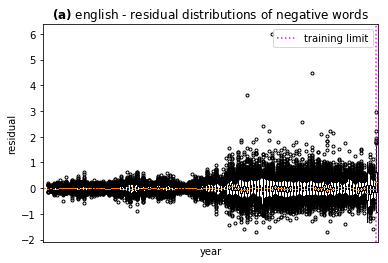

In [99]:
R_eng_neg = Z_eng_neg-Z_eng_reco_neg
plt.figure()
plt.boxplot(R_eng_neg,sym='.')
plt.axvline(TR_train+1,linestyle=':',color='magenta',label='training limit')
plt.xlabel('year')
plt.ylabel('residual')
plt.xticks([])
plt.title(r'$\mathbf{(a)}$ english - residual distributions of negative words')
plt.legend(loc=0)
plt.show()

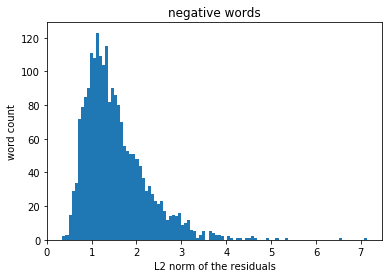

In [100]:
R_norm = np.linalg.norm(R_eng_neg,ord=2,axis=1)

plt.hist(R_norm,bins=100)
plt.xlabel('L2 norm of the residuals')
plt.ylabel('word count')
plt.title('negative words')
plt.show()

In [101]:
# low 2-norm means high rank?
# high 2-norm means low rank?

In [102]:
P_avg_neg = np.mean(P_eng_neg,axis=1)
P_avg_neg.shape

(2153,)

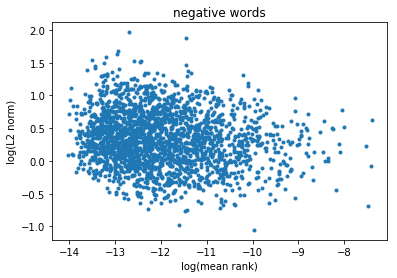

In [103]:
plt.plot(np.log(P_avg_neg),np.log(R_norm),'.')
plt.xlabel('log(mean rank)')
plt.ylabel('log(L2 norm)')
plt.title('negative words')
plt.show()

In [104]:
P_var_neg = variation(P_eng_neg,axis=1)
P_var_neg.shape

(2153,)

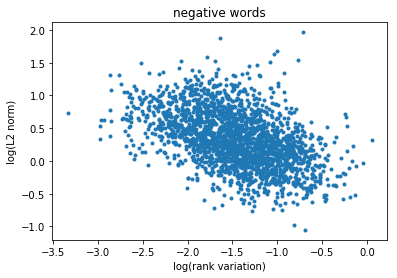

In [105]:
plt.plot(np.log(P_var_neg),np.log(R_norm),'.')
plt.xlabel('log(rank variation)')
plt.ylabel('log(L2 norm)')
plt.title('negative words')
plt.show()

### Positive

In [106]:
# Positive matrix
TR_train = 108 # years

### English dataset!
# step 1: extract training data
Z_eng_0 = Z_eng_pos[:,0:TR_train]
Z_eng_1 = Z_eng_pos[:,1:TR_train+1]

# step 2: compute SVD
U,S,VH = svd(Z_eng_0)

# step 3: compute inverted singular values (~99% of explained variance/normalized energy)
Sinv = np.zeros((TR_train,Z_eng_pos.shape[0]),dtype=float)
Nsvals = 68
for j, i in enumerate(S[0:Nsvals]):
    Sinv[j,j]=1/i
    
# step 4: compute DMD matrix
A_eng_pos = np.matmul( Z_eng_1, np.matmul( np.matmul( VH.conj().T, Sinv ), U.conj().T ) )
A_eng_pos.shape

(1849, 1849)

In [107]:
# reconstruct time-series using learned A
Z_eng_reco_pos = np.matmul(A_eng_pos,Z_eng_0) # matrix A multiplied by the original data

# test time-series beyond training limit using learned A
for t in range(0,Z_eng_pos.shape[1]-TR_train):
    reco_next_pos = np.matmul(A_eng_pos,Z_eng_reco_pos)
    Z_eng_reco_pos = np.insert(Z_eng_reco_pos,Z_eng_reco_pos.shape[1],
                               reco_next_pos[:,reco_next_pos.shape[1]-1],axis=1)

# corrections (insert initial and delete last)
Z_eng_reco_pos = np.insert(Z_eng_reco_pos,0,Z_eng_0[:,0],axis=1)
Z_eng_reco_pos = np.delete(Z_eng_reco_pos,Z_eng_reco_pos.shape[1]-1,axis=1)
Z_eng_reco_pos.shape

(1849, 109)

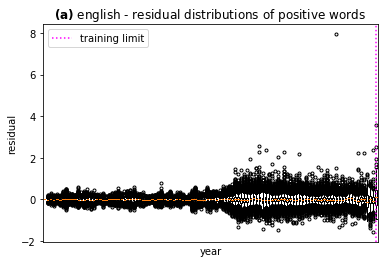

In [108]:
R_eng_pos = Z_eng_pos-Z_eng_reco_pos
plt.figure()
plt.boxplot(R_eng_pos,sym='.')
plt.axvline(TR_train+1,linestyle=':',color='magenta',label='training limit')
plt.xlabel('year')
plt.ylabel('residual')
plt.xticks([])
plt.title(r'$\mathbf{(a)}$ english - residual distributions of positive words')
plt.legend(loc=0)
plt.show()

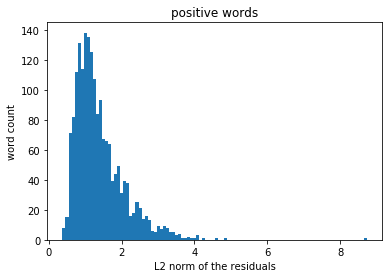

In [109]:
R_norm = np.linalg.norm(R_eng_pos,ord=2,axis=1)

plt.hist(R_norm,bins=100)
plt.xlabel('L2 norm of the residuals')
plt.ylabel('word count')
plt.title('positive words')
plt.show()

In [110]:
P_avg_pos = np.mean(P_eng_pos,axis=1)
P_avg_pos.shape

(1849,)

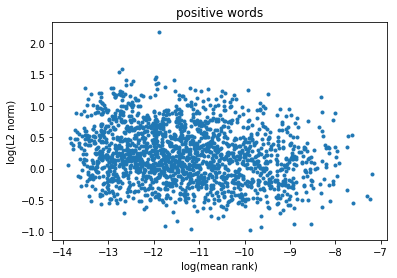

In [111]:
plt.plot(np.log(P_avg_pos),np.log(R_norm),'.')
plt.xlabel('log(mean rank)')
plt.ylabel('log(L2 norm)')
plt.title('positive words')
plt.show()

In [112]:
P_var_pos = variation(P_eng_pos,axis=1)
P_var_pos.shape

(1849,)

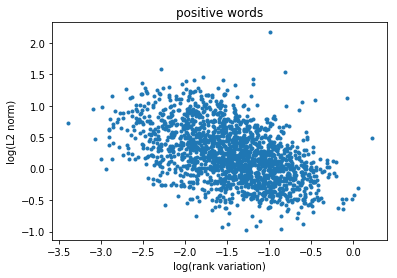

In [113]:
plt.plot(np.log(P_var_pos),np.log(R_norm),'.')
plt.xlabel('log(rank variation)')
plt.ylabel('log(L2 norm)')
plt.title('positive words')
plt.show()

### Intersection (+ and -)